<a href="https://colab.research.google.com/github/kabbas570/EMBL/blob/main/Abbas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Approach:***
# This Jupyter Notebook presents a project that aims to predict **Proteomics** (protein expression levels) from **Transcriptomics** (gene expression) for the skin dataset.

# ***Data Preparation:***
The original datasets contained 15,278 gene expression features (transcriptomics) and 4,922 protein expression features (proteomics). To ensure alignment between the two modalities, the overlapping genes are identified present in both datasets using set operations.

This filtering resulted in reduced versions of the datasets, each containing only the shared genes; A total of 4,886 features. These aligned datasets were then used for model training and evaluation.


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# Loading the data
proteomics_df = pd.read_csv('/content/drive/MyDrive/EMBL_Task/Skin/high_low_correlation_proteomics.csv')
transcriptomics_df  = pd.read_csv('/content/drive/MyDrive/EMBL_Task/Skin/high_low_correlation_transcriptomics.csv')

# Identify common genes and filter datasets
protein_names = set(proteomics_df.columns)
common_genes = [gene for gene in transcriptomics_df.columns if gene in protein_names]
filtered_transcriptomics_df = transcriptomics_df[common_genes]

# Find common columns between proteomics and transcriptomics
common_columns = sorted(list(set(proteomics_df.columns).intersection(set(transcriptomics_df.columns))))
filtered_proteomics_df = proteomics_df[common_columns]
filtered_transcriptomics_df = transcriptomics_df[common_columns]
common_names = [col for col in common_columns if col != 'Unnamed: 0']


# **Train-Validation Split:**
The skin dataset contains a total of 45 participants. For simplicity and consistency, the data is divided as follows:

First 40 participants → Training set

Last 5 participants → Validation set

In [15]:

# Split the data into train and validation sets
train_df_proteomics = filtered_proteomics_df.iloc[:40]
val_df_proteomics = filtered_proteomics_df.iloc[40:]
train_df_transcriptomics = filtered_transcriptomics_df.iloc[:40]
val_df_transcriptomics = filtered_transcriptomics_df.iloc[40:]

# **Dataset and DataLoader:**
A custom PyTorch Dataset class is used to pair transcriptomics and proteomics data for each participant. It returns tensors for both data types along with the subject ID.
The DataLoader wraps this dataset for training and validation, enabling efficient batching and shuffling.

In [16]:
# Dataset class
class MultiOmicsDataset(Dataset):
    def __init__(self, proteomics_df, transcriptomics_df):
        self.subject_ids = proteomics_df["Unnamed: 0"].values
        self.proteomics_data = torch.tensor(proteomics_df.drop(columns=['Unnamed: 0']).values, dtype=torch.float32)
        self.transcriptomics_data = torch.tensor(transcriptomics_df.drop(columns=['Unnamed: 0']).values, dtype=torch.float32)

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        return {
            'subject_id': self.subject_ids[idx],
            'proteomics': self.proteomics_data[idx],
            'transcriptomics': self.transcriptomics_data[idx]
        }

# Create DataLoader
train_dataset = MultiOmicsDataset(train_df_proteomics, train_df_transcriptomics)
val_dataset = MultiOmicsDataset(val_df_proteomics, val_df_transcriptomics)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# **Model: TranscriptToProteomicsTransformer**
A transformer-based model is designed to predict proteomics data from transcriptomics input. Each gene expression value is treated as a token and projected into a higher-dimensional space. The model applies positional encoding and passes the tokens through a multi-layer transformer encoder, then maps the output back to protein expression values using a final linear layer.

In [17]:
# Create the model
class TranscriptToProteomicsTransformer(nn.Module):
    def __init__(self, feature_dim=32, d_model=64, nhead=2, num_layers=2, dim_feedforward=64, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.d_model = d_model
        self.input_proj = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, feature_dim, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        B, F = x.shape
        x = x.unsqueeze(-1)
        x = self.input_proj(x)
        x = x + self.pos_embedding[:, :F, :]
        x = self.transformer_encoder(x)  # [B, F, d_model]
        x = self.output_proj(x).squeeze(-1)  # [B, F]
        return x
model = TranscriptToProteomicsTransformer().to(device=DEVICE,dtype=torch.float)

# **Loss Function and Optimizer:**
The model is trained using Mean Squared Error (MSE) loss to measure the difference between predicted and actual protein expression values.
The Adam optimizer is used with a learning rate of 1e-3.

In [18]:
# Define the optimizer and loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## **Training and Validation Functions**
**train_fn:** Trains the model by computing the loss, backpropagating gradients, and updating weights.

**validate_fn:** Evaluates the model using MSE Loss.

Both functions return the average loss for the epoch.

In [19]:
# Training function
def train_fn(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for batch in train_loader:
        x = batch['transcriptomics'].to(device=DEVICE, dtype=torch.float)
        y = batch['proteomics'].to(device=DEVICE, dtype=torch.float)
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(float(loss))
    return np.mean(train_losses)
# Validation function
def validate_fn(model, val_loader):
    model.eval()
    val_losses = []
    with torch.no_grad():  # No need to track gradients during validation
        for batch in val_loader:
            x = batch['transcriptomics']
            y = batch['proteomics']
            pred = model(x)
            loss = criterion(pred, y)
            val_losses.append(float(loss))
    return np.mean(val_losses)

# **Checkpoint Saving:**
A utility function to save model checkpointsto a specified path in .pth.tar format for later use during inference.

In [20]:
path_to_save_check_points = '/content/drive/MyDrive/EMBL_Task/Skin/'
def save_checkpoint(state,name):
    print("=> Saving checkpoint")
    filename = path_to_save_check_points + name + ".pth.tar"
    torch.save(state, filename)

## **Training Loop:**
The training loop runs for **100** epochs. During each epoch, the model is trained using the **train_fn** function, and validated using the **validate_fn** function. The training and validation losses are recorded for each epoch. The best loss is monitored, and if the validation loss improves, the model's state is saved as a checkpoint corresponding to the minimum val_loss observed during the training process.

# **Learning Curve Visualization**
The **plot_losses** function visualizes the training and validation losses over epochs

In [21]:
def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_Epochs + 1), train_losses_record, label="Train Loss", color='blue')#, marker='o')
    plt.plot(range(1, Max_Epochs + 1), val_losses_record, label="Val Loss", color='red')#, marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/100], Train Loss: 7.99149, Val Loss: 3.84845
=> Saving checkpoint
Epoch [2/100], Train Loss: 4.64221, Val Loss: 3.07525
=> Saving checkpoint
Epoch [3/100], Train Loss: 3.48244, Val Loss: 2.22465
=> Saving checkpoint
Epoch [4/100], Train Loss: 2.71340, Val Loss: 2.36253
Epoch [5/100], Train Loss: 2.42546, Val Loss: 2.59955
Epoch [6/100], Train Loss: 1.99698, Val Loss: 1.66796
=> Saving checkpoint
Epoch [7/100], Train Loss: 1.50990, Val Loss: 0.71757
=> Saving checkpoint
Epoch [8/100], Train Loss: 1.47702, Val Loss: 0.75038
Epoch [9/100], Train Loss: 1.17575, Val Loss: 1.04762
Epoch [10/100], Train Loss: 0.96377, Val Loss: 0.49980
=> Saving checkpoint
Epoch [11/100], Train Loss: 0.88636, Val Loss: 0.32007
=> Saving checkpoint
Epoch [12/100], Train Loss: 0.79515, Val Loss: 0.39721
Epoch [13/100], Train Loss: 0.78394, Val Loss: 0.26456
=> Saving checkpoint
Epoch [14/100], Train Loss: 0.68862, Val Loss: 0.42671
Epoch [15/100], Train Loss: 0.55870, Val Loss: 0.34218
Epoch [16/100], 

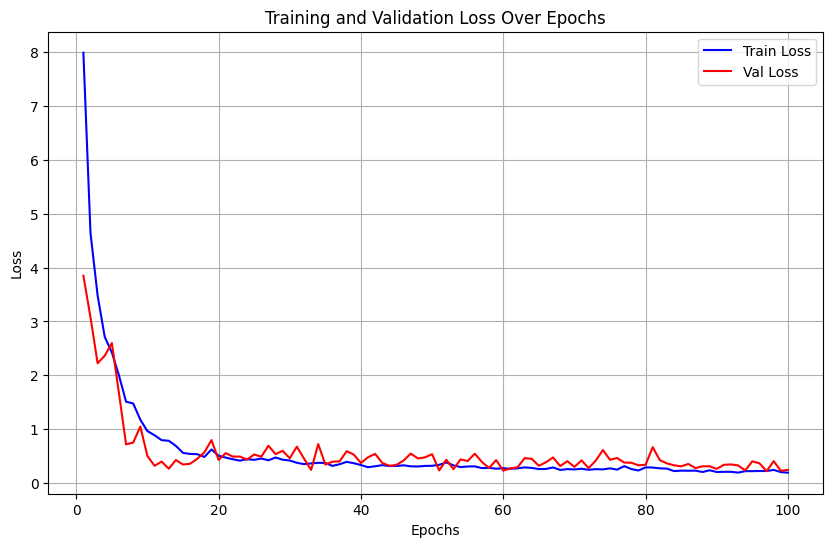

In [22]:
# Training loop
Max_Epochs = 100
train_losses_record = []  # losses of all training epochs
val_losses_record = []    # losses of all validation epochs

def main():
    min_val_loss = 10000
    for epoch in range(Max_Epochs):
        # Training
        train_loss = train_fn(model, train_loader, optimizer)
        train_losses_record.append(train_loss)

        # Validation
        val_loss = validate_fn(model, val_loader)
        val_losses_record.append(val_loss)

        # Print both train and validation loss for each epoch
        print(f"Epoch [{epoch+1}/{Max_Epochs}], Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        if val_loss < min_val_loss:
             min_val_loss = val_loss
            # Save the checkpoint
             checkpoint = {
                  "state_dict": model.state_dict(),
                  }
             save_checkpoint(checkpoint,'High_Low_Correlation_Model')
    # After training is complete, plot the loss curves
    plot_losses()
if __name__ == "__main__":
    main()

# **Evaluaiton Metrices**
The **evaluate_metrics** computes various evaluation metrics to assess the performance of the model's predictions against the true values. The metrics calculated are:

1. Pearson Correlation Coefficient
2. Mean Squared Error (MSE)
3. Root Mean Squared Error (RMSE)
4. Mean Absolute Error (MAE)
5. R-squared (R²)

In [23]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_metrics(y_true, y_pred):
    metrics = {}
    y_true = y_true.numpy().flatten()
    y_pred = y_pred.numpy().flatten()

    # Pearson Correlation Coefficient
    metrics['Pearson Correlation Coefficient'] = np.corrcoef(y_true, y_pred)[0, 1]

    # Mean Squared Error (MSE)
    metrics['Mean Squared Error (MSE)'] = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    metrics['Root Mean Squared Error (RMSE)'] = np.sqrt(metrics['Mean Squared Error (MSE)'])

    # Mean Absolute Error (MAE)
    metrics['Mean Absolute Error (MAE)'] = mean_absolute_error(y_true, y_pred)

    # R-squared (R²)
    metrics['R-squared (R²)'] = r2_score(y_true, y_pred) # r2_score(true_np, pred_np)
    return metrics

# **Evaluation Visualizations**
The **plot_evaluation** function generates three key visualizations to assess the model's prediction performance:

1. Scatter Plot: Shows the actual protein expression values vs. predicted values, with a red dashed line representing the ideal prediction (perfect match).

2. Residual Plot: Displays the difference between predicted and actual values (residuals) against predicted values, highlighting how well the model captures the patterns in the data.

3. Prediction vs. Actual Expression (Bar Plot): Compares actual and predicted protein expression levels for each gene, providing a visual representation of the model's accuracy per gene.

In [24]:
def plot_evaluation(true, pred, gene_names=None):
    true = np.asarray(true)
    pred = np.asarray(pred)

    n_samples, n_features = true.shape

    #  1. Scatter Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(true.flatten(), pred.flatten(), alpha=0.7, color='b')
    plt.xlabel('Actual Protein Expression')
    plt.ylabel('Predicted Protein Expression')
    plt.title('Scatter Plot: Predicted vs. Actual Protein Expression')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal')
    plt.legend()
    plt.grid(True)
    plt.show()

    #  2. Residual Plot
    residuals = pred - true
    plt.figure(figsize=(8, 6))
    plt.scatter(pred.flatten(), residuals.flatten(), alpha=0.7, color='g')
    plt.xlabel('Predicted Protein Expression')
    plt.ylabel('Residuals (Predicted - Actual)')
    plt.title('Residual Plot')
    plt.axhline(0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()

    # 3. Prediction vs. Actual Expression for Each Gene (Line Plot)
    plt.figure(figsize=(12, 6))
    x = np.arange(n_features)
    width = 0.35
    plt.bar(x - width/2, true[0], width, label='Actual', color='blue')
    plt.bar(x + width/2, pred[0], width, label='Predicted', color='orange')
    plt.xlabel('Genes')
    plt.ylabel('Protein Expression')
    plt.title('Protein Expression per Gene: Actual vs Predicted')
    plt.xticks(x, gene_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# **Performance Evaluation**
Load the pre-trained TranscriptToProteomicsTransformer model from a saved checkpoint and evaluate its performance on the validation set.

(32,) (32,)
Quanitative Results for : ['SIDM01105']
                         Metric    Value
Pearson Correlation Coefficient 0.988959
       Mean Squared Error (MSE) 0.151945
 Root Mean Squared Error (RMSE) 0.389801
      Mean Absolute Error (MAE) 0.317031
                 R-squared (R²) 0.969502


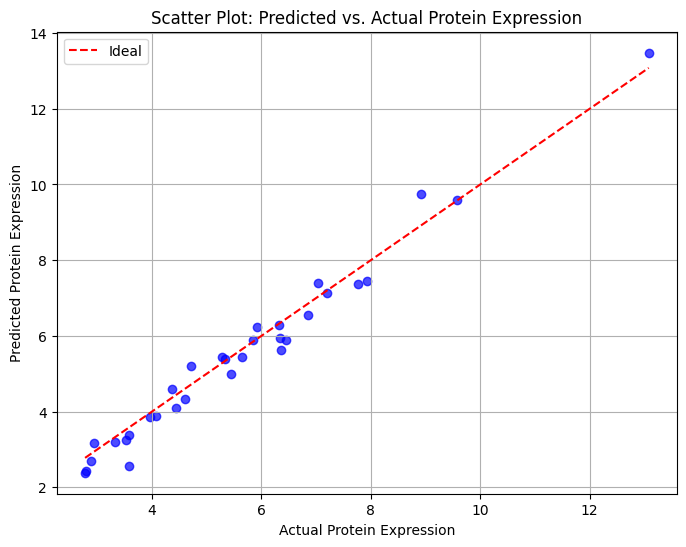

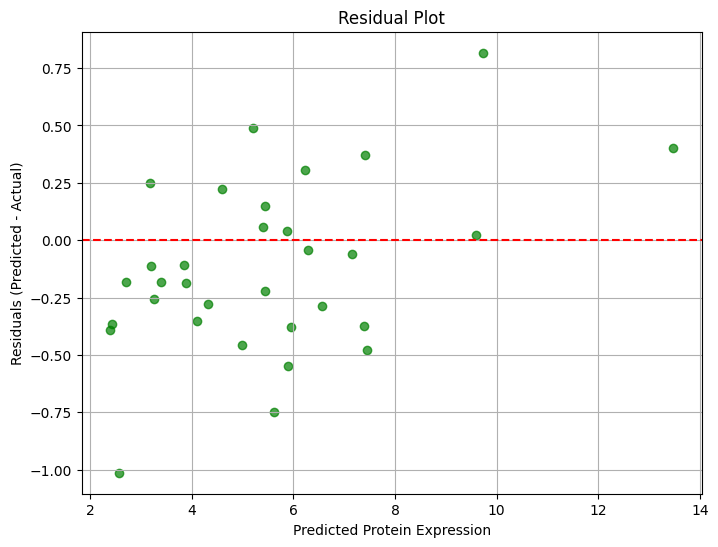

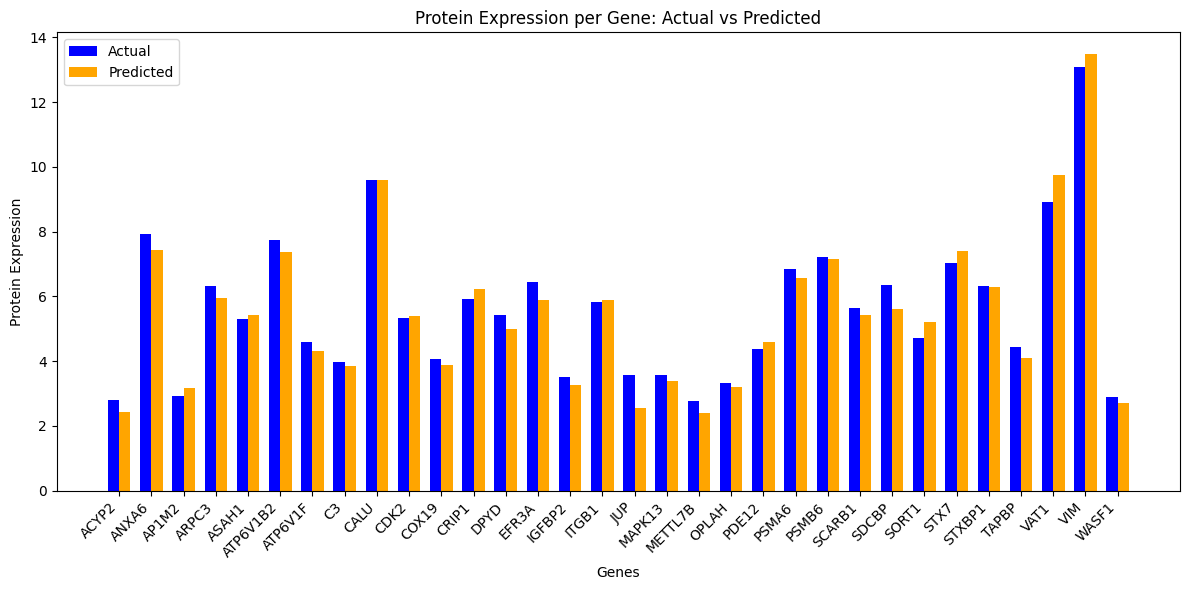

(32,) (32,)
Quanitative Results for : ['SIDM01107']
                         Metric    Value
Pearson Correlation Coefficient 0.975785
       Mean Squared Error (MSE) 0.234796
 Root Mean Squared Error (RMSE) 0.484557
      Mean Absolute Error (MAE) 0.372606
                 R-squared (R²) 0.951691


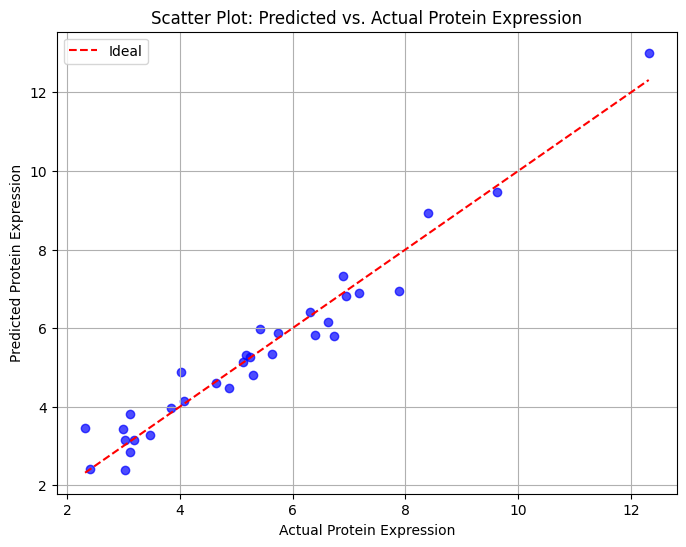

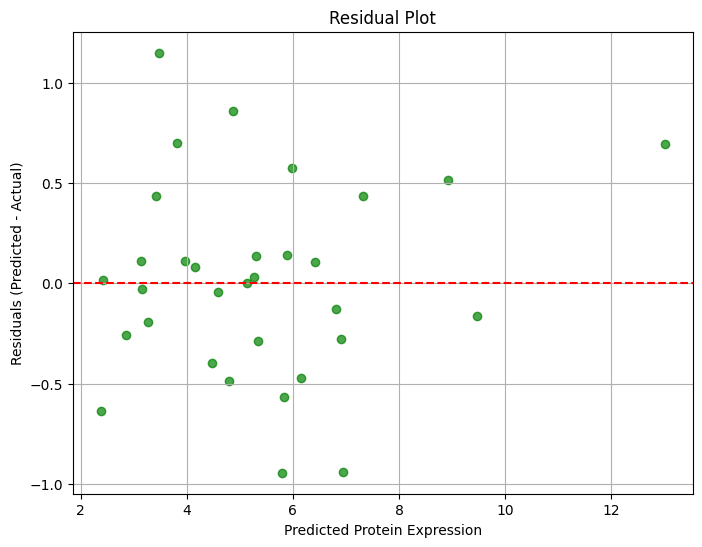

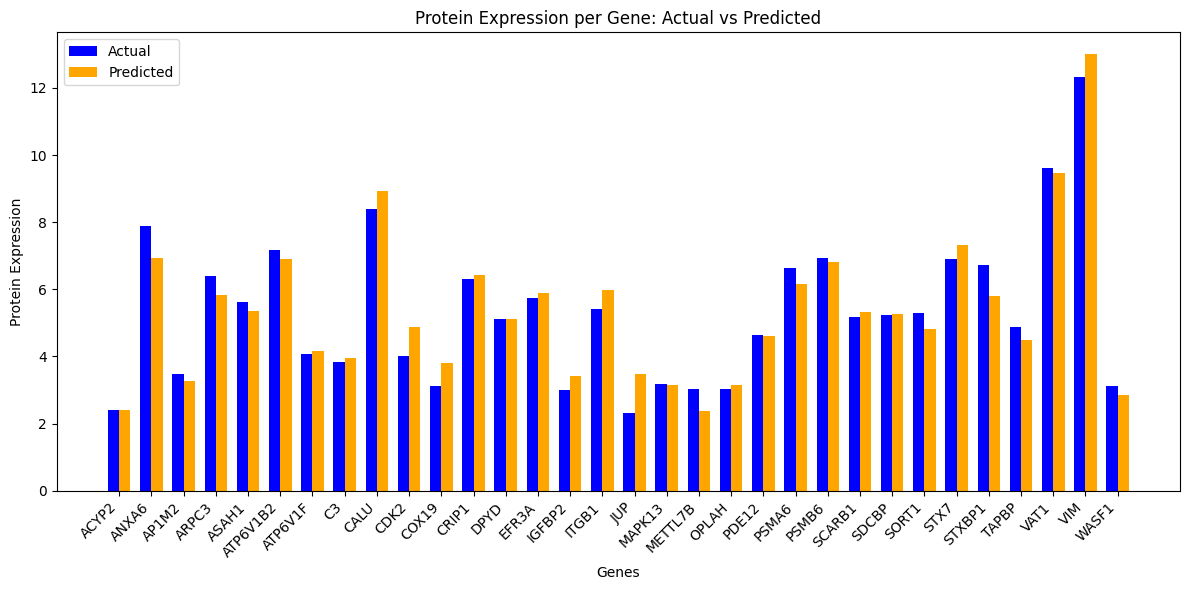

(32,) (32,)
Quanitative Results for : ['SIDM01228']
                         Metric    Value
Pearson Correlation Coefficient 0.951943
       Mean Squared Error (MSE) 0.434081
 Root Mean Squared Error (RMSE) 0.658848
      Mean Absolute Error (MAE) 0.474039
                 R-squared (R²) 0.878694


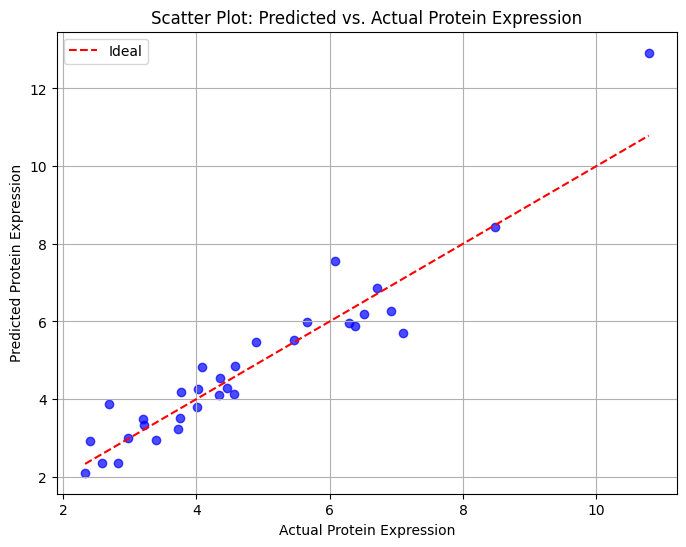

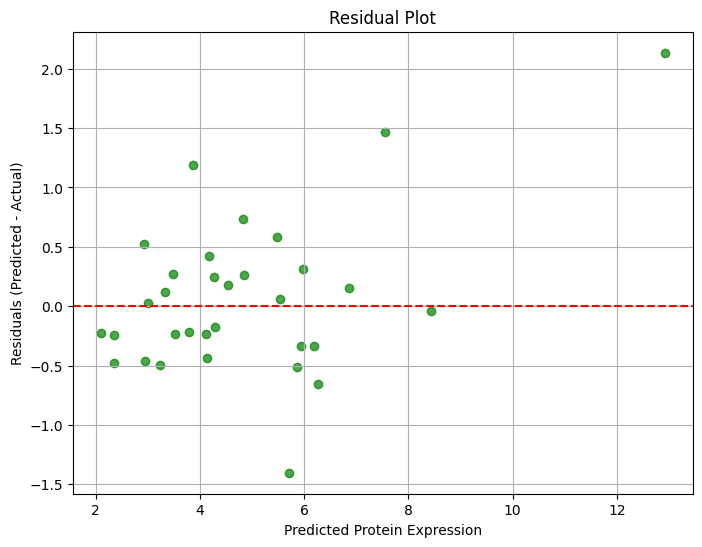

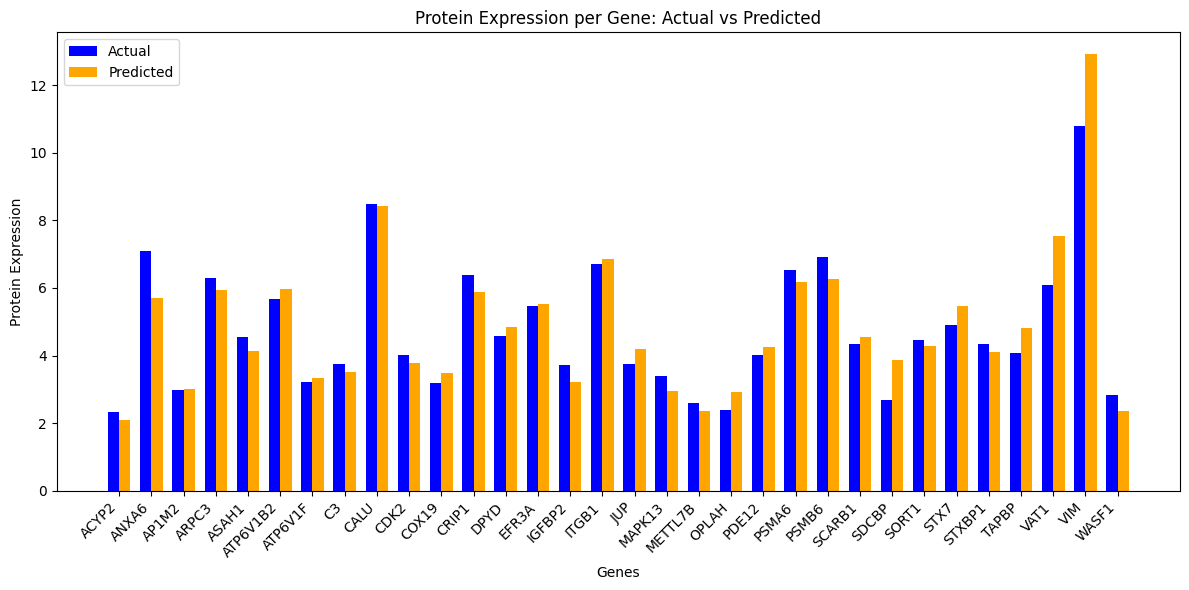

(32,) (32,)
Quanitative Results for : ['SIDM01240']
                         Metric    Value
Pearson Correlation Coefficient 0.988824
       Mean Squared Error (MSE) 0.180640
 Root Mean Squared Error (RMSE) 0.425018
      Mean Absolute Error (MAE) 0.342606
                 R-squared (R²) 0.958421


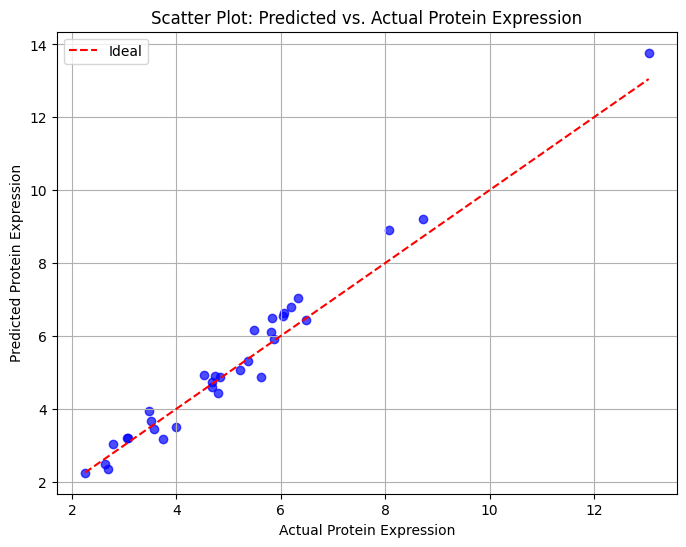

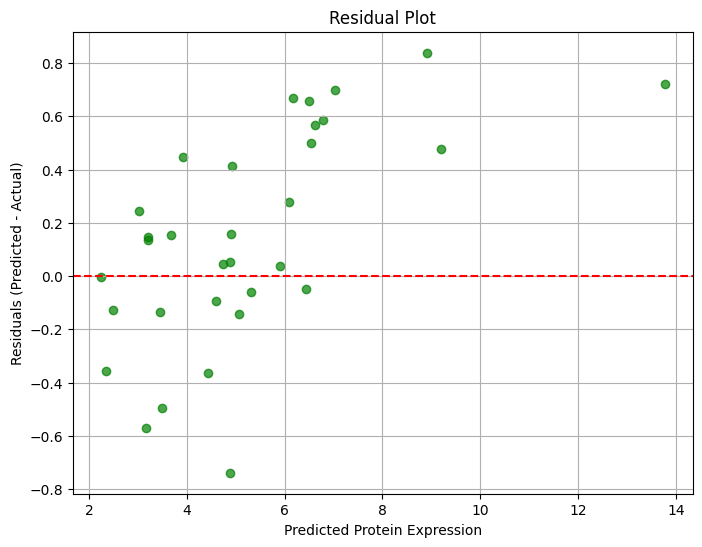

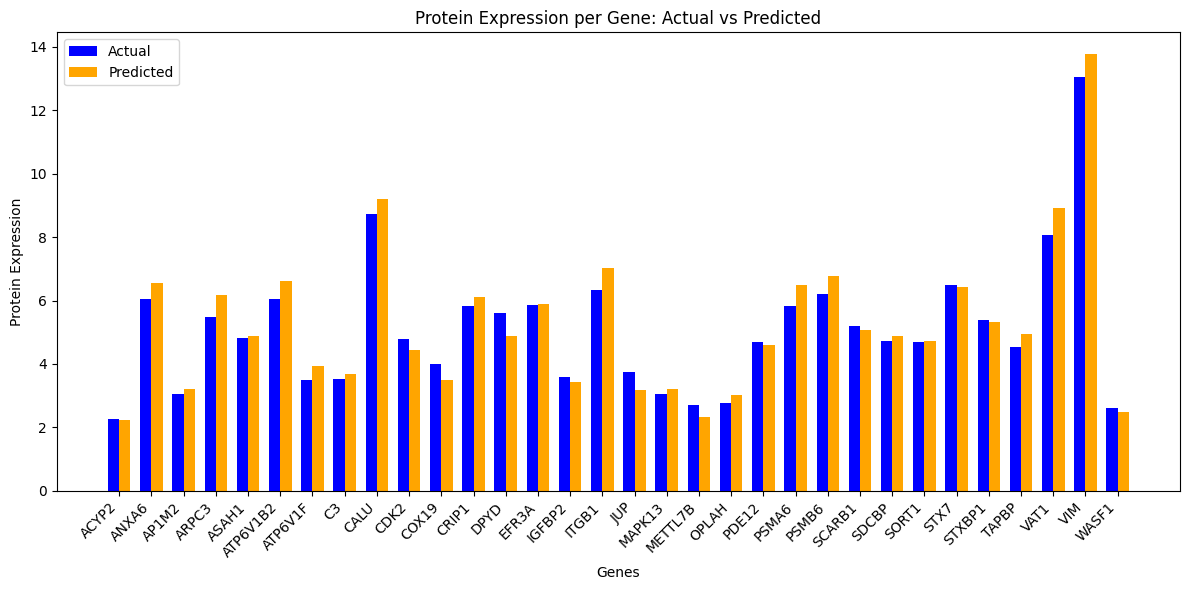

(32,) (32,)
Quanitative Results for : ['SIDM01242']
                         Metric    Value
Pearson Correlation Coefficient 0.992944
       Mean Squared Error (MSE) 0.100110
 Root Mean Squared Error (RMSE) 0.316401
      Mean Absolute Error (MAE) 0.258720
                 R-squared (R²) 0.978408


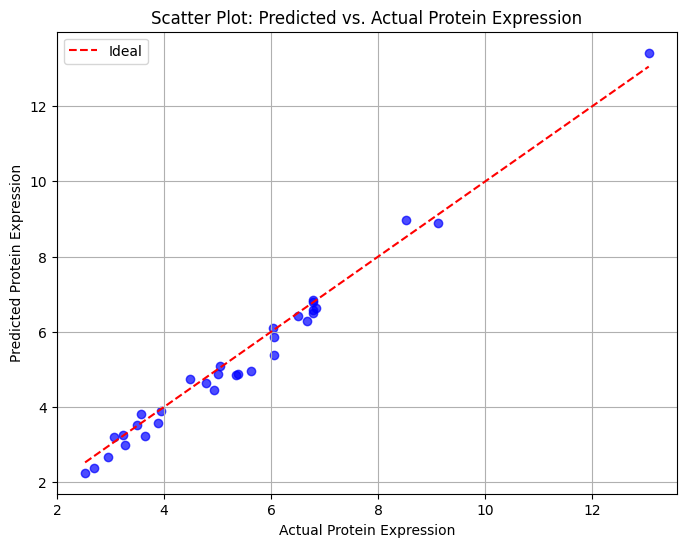

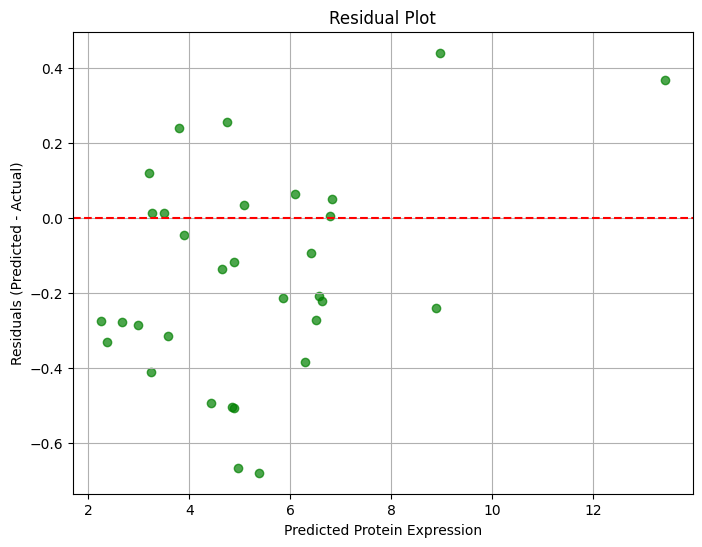

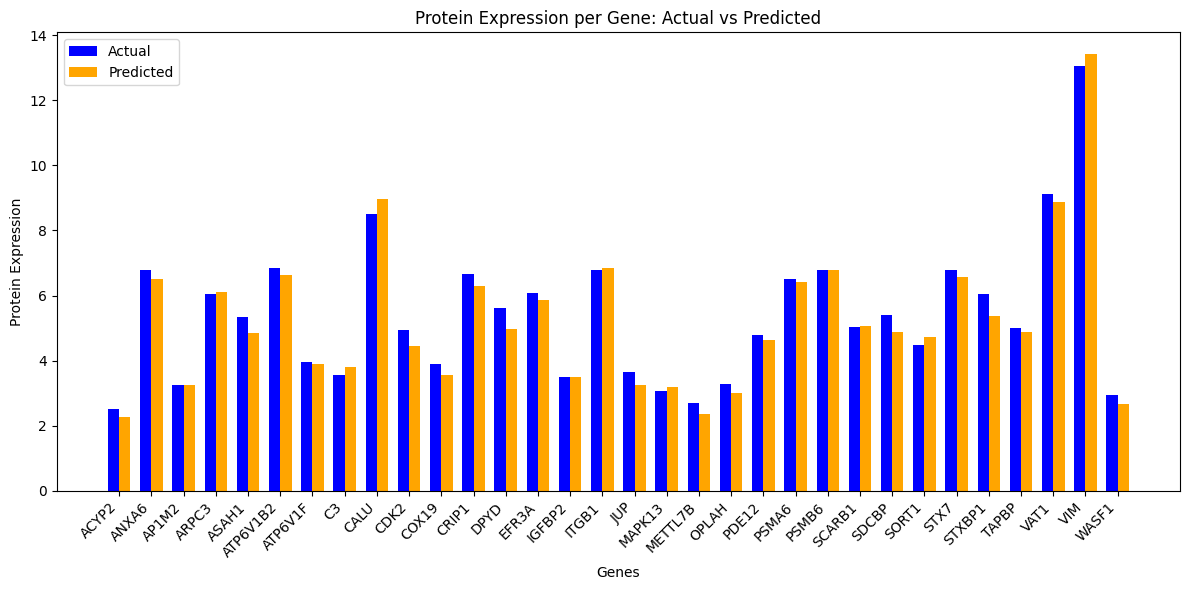

In [25]:
def validate_fn(model, val_loader):
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            x = batch['transcriptomics'].to(device=DEVICE, dtype=torch.float)
            y_true = batch['proteomics'].to(device=DEVICE, dtype=torch.float)
            ID = batch['subject_id']
            y_pred = model(x)

            metrics = evaluate_metrics(y_true, y_pred)
            metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
            # Print the results as a table
            print('Quanitative Results for :', ID)
            print(metrics_df.to_string(index=False))
            plot_evaluation(y_true, y_pred, gene_names=common_names)
path_to_checkpoints = '/content/drive/MyDrive/EMBL_Task/Skin/High_Low_Correlation_Model.pth.tar'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def eval_():
        model = TranscriptToProteomicsTransformer().to(device=DEVICE,dtype=torch.float)
        checkpoint = torch.load(path_to_checkpoints,map_location=DEVICE)
        model.load_state_dict(checkpoint['state_dict'])
        validate_fn(model, val_loader)

if __name__ == "__main__":
    eval_()